In [1]:
#packages
import pandas as pd
import numpy as np
import datetime
from pandas_datareader import DataReader
import matplotlib.pyplot as plt

In [2]:
#reading fb, amzn, aapl & ibm data from yahoo finance api
fb=DataReader('FB','yahoo','01-01-2018','31-12-2018')
amzn=DataReader('AMZN','yahoo','01-01-2018','31-12-2018')
aapl=DataReader('AAPL','yahoo','01-01-2018','31-12-2018')
ibm=DataReader('IBM','yahoo','01-01-2018','31-12-2018')

In [3]:
#calculating cumulative return for 2018 aka 'Normed Return'
#its calculated by taking the adjusted closing price and dividing by the initial price in the period
for stock_df in (fb,amzn,aapl,ibm):
    stock_df['Normed Return']=stock_df['Adj Close']/stock_df['Adj Close'][0]

In [4]:
#allocate initially 20% fb, 40% amzn, 30% aapl, 10% ibm
for stock_df, allo in zip((fb, amzn, aapl, ibm),[.2,.4,.3,.1]):
    stock_df['Allocation'] = stock_df['Normed Return']*allo

In [5]:
#position value assuming an intial portfolio of $1 million
for stock_df in (fb,amzn,aapl,ibm):
    stock_df['Position Value']=stock_df['Allocation']*1000000

In [6]:
#create list of all position values and concatenate into single dataframe
all_pos_vals=[fb['Position Value'],amzn['Position Value'],aapl['Position Value'],ibm['Position Value']]
portfolio_val=pd.concat(all_pos_vals,axis=1)
portfolio_val.columns=['FB','AMZN','AAPL','IBM']
portfolio_val['Total']=portfolio_val.sum(axis=1)

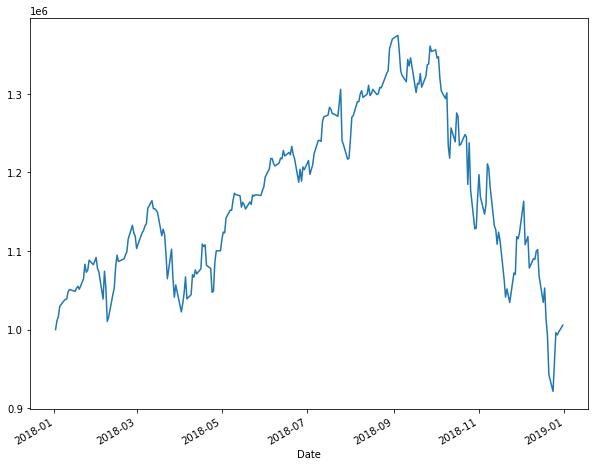

In [7]:
#plot the performance of the portfolio over the period
portfolio_val['Total'].plot(figsize=(10,8))

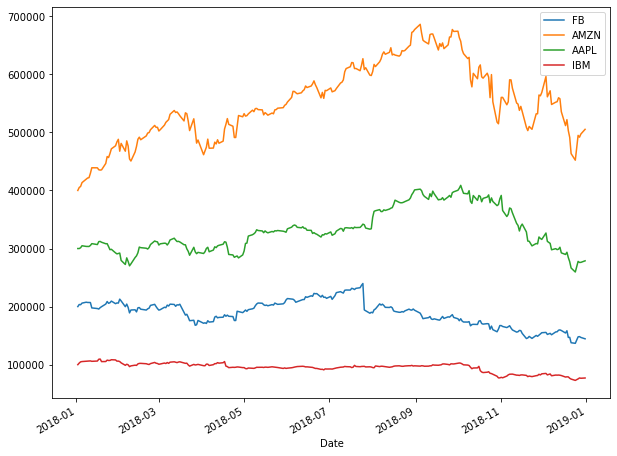

In [8]:
#individual position's performance
portfolio_val.drop('Total',axis=1).plot(figsize=(10,8))

In [9]:
#calculating daily return
portfolio_val['Daily Return']=portfolio_val['Total'].pct_change(1)

In [10]:
portfolio_val.head()

,FB,AMZN,AAPL,IBM,Total,Daily Return
Date,,,,,,
2018-01-02,200000.000000,400000.000000,300000.000000,100000.000000,1.000000e+06,NaN
2018-01-03,203582.846470,405110.113887,299947.705204,102748.821591,1.011389e+06,0.011389
2018-01-04,203208.029646,406923.392027,301340.946632,104829.833917,1.016302e+06,0.004857
2018-01-05,205986.118388,413500.308510,304771.782974,105342.001998,1.029600e+06,0.013085
2018-01-08,207562.562760,419464.927924,303639.822556,105977.336369,1.036645e+06,0.006842


In [11]:
#calculating average daily return
portfolio_val['Daily Return'].mean()

0.00018517397146043413

In [12]:
#calculating standard deviation in Daily Return
portfolio_val['Daily Return'].std()

0.018044558952634467

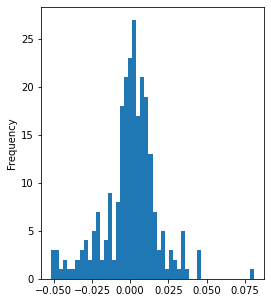

In [13]:
#histogram plot of daily return
portfolio_val['Daily Return'].plot(kind='hist', bins=50, figsize=(4,5))

In [14]:
cum_return = 100 * (portfolio_val['Total'][-1]/portfolio_val['Total'][0] - 1)

In [15]:
sharpe_ratio = portfolio_val['Daily Return'].mean() / portfolio_val['Daily Return'].std()

In [16]:
ASR=(252**0.5)*sharpe_ratio

In [17]:
#Generally a Sharpe Ratio above 1 is considered acceptable to investors (of course depending on risk-tolerance), 
#a ratio of 2 is very good, and a ratio above 3 is considered to be excellent.

In [18]:
#MONTE CARLO SIMULATIONS
#get only adj close of 4 companies
stocks=pd.concat([fb['Adj Close'],amzn['Adj Close'],aapl['Adj Close'],ibm['Adj Close']],axis=1)
stocks.columns=['fb','amzn','aapl','ibm']

In [19]:
stocks.head()

,fb,amzn,aapl,ibm
Date,,,,
2018-01-02,181.419998,1189.010010,166.054321,135.743759
2018-01-03,184.669998,1204.199951,166.025375,139.475113
2018-01-04,184.330002,1209.589966,166.796555,142.299957
2018-01-05,186.850006,1229.140015,168.695572,142.995193
2018-01-08,188.279999,1246.869995,168.069016,143.857620


In [20]:
#log daily return
log_return=np.log(stocks/stocks.shift(1))

In [21]:
log_return.head()

,fb,amzn,aapl,ibm
Date,,,,
2018-01-02,NaN,NaN,NaN,NaN
2018-01-03,0.017756,0.012694,-0.000174,0.027117
2018-01-04,-0.001843,0.004466,0.004634,0.020051
2018-01-05,0.013579,0.016033,0.011321,0.004874
2018-01-08,0.007624,0.014322,-0.003721,0.006013


In [22]:
print(stocks.columns)

Index(['fb', 'amzn', 'aapl', 'ibm'], dtype='object')


In [23]:
#random weights
weights=np.array(np.random.random(4))
print(weights)

[0.38583145 0.04587285 0.39888027 0.96441054]


In [24]:
#rebalance weights so they add up to one
weights = weights/weights.sum()
print(weights)

[0.21494847 0.02555597 0.22221803 0.53727753]


In [25]:
#expected return
exp_ret = np.sum((log_return.mean()*weights)*252)

In [26]:
print(exp_ret)

-0.2221403028925395


In [27]:
# expected volatility
exp_vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252, weights)))
print(exp_vol)

0.22823765922735645


In [28]:
# Sharpe Ratio
SR = exp_ret/exp_vol
print(SR)

-0.9732850557815127


In [29]:
num_ports = 5000
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports): 
    # weights 
    weights = np.array(np.random.random(4)) 
    weights = weights/np.sum(weights)  
	
    # save the weights
    all_weights[ind,:] = weights
	
    # expected return 
    ret_arr[ind] = np.sum((log_return.mean()*weights)*252)

    # expected volatility 
    vol_arr[ind] = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252, weights)))

    # Sharpe Ratio 
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [30]:
sharpe_arr.max()

0.45386754861868644

In [31]:
sharpe_arr.argmax()

1399

In [32]:
all_weights[2101,:]

array([0.06631537, 0.1888347 , 0.44436365, 0.30048627])

Text(0, 0.5, 'Return')

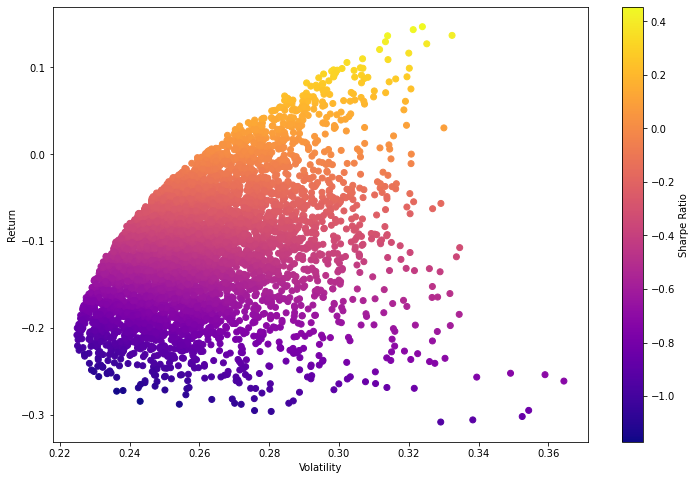

In [33]:
# plot the data
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

In [34]:
max_sr_ret = ret_arr[4988]
max_sr_vol = vol_arr[4988]

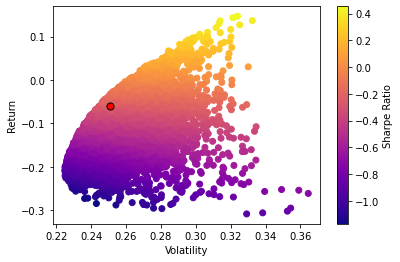

In [35]:
# plot the dataplt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# add a red dot for max_sr_vol & max_sr_ret
plt.scatter(max_sr_vol, max_sr_ret, c='red', s=50, edgecolors='black')

In [46]:
#OPTIMISATION ALGORITHM - SCIPY
def get_ret_vol_sr(weights):
    weights=np.array(weights)
    ret=np.sum(log_return.mean()*weights)*252
    vol=np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252,weights)))
    sr = ret/vol 
    return np.array([ret,vol,sr])

In [37]:
from scipy.optimize import minimize

In [38]:
# minimize negative Sharpe Ratio
def neg_sharpe(weights): 
    return get_ret_vol_sr(weights)[2] * -1

In [39]:
# check allocation sums to 1
def check_sum(weights): 
    return np.sum(weights) - 1

In [40]:
# create constraint variable
cons = ({'type':'eq','fun':check_sum})

In [41]:
# create weight boundaries
bounds = ((0,1),(0,1),(0,1),(0,1))

In [42]:
# initial guess
init_guess = [0.25, 0.25, 0.25, 0.25]

In [47]:
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

In [48]:
opt_results

     fun: -0.6507186950181597
     jac: array([ 1.30497344e+00, -7.45058060e-09,  5.44596314e-01,  9.35329638e-01])
 message: 'Optimization terminated successfully'
    nfev: 10
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([4.99600361e-16, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [49]:
opt_results.x

array([4.99600361e-16, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [50]:
get_ret_vol_sr(opt_results.x)

array([0.23552578, 0.36194715, 0.6507187 ])

In [ ]:
#END 